# 구조
### 1. Convolutional Layer n°1 with 32 filters
        1- Max pooling
        2- Relu
        
### 2. Convolutional Layer n°2 with 64 filters
        1- Max pooling
        2- Relu
        3- DropOut
      
### 3. Flatten Layer

### 4. Fully Connected Layer with 100 nodes
        1- Relu
        2- DropOut

### 5. Fully Connected Layer with n nodes (n = number of breeds)

#### *컴퓨터 성능이 좋다면 더 많은 ConvNet을 만들어도 된다. 학생이기에 컴퓨터 성능이 아주 좋지 않아 그래픽카드없는 노트북 로컬에서 돌리기 때문에 2개 층만 사용하였다


#### <<< 이 코드에서 사용되는 데이터는 Kaggle Dog Breed Identification프로젝트 데이터를 사용했습니다.
#### 이 코드는 Kernels에 공개되어 있는 Simple Convolutional N. Network with Tensorflow 제목의 코드를 보며, 직접 조금씩 CNN부분을  변경해보기도 한 
#### 코드입니다. 원본 코드를 보고싶으시면 https://www.kaggle.com/kaggleslayer/simple-convolutional-n-network-with-tensorflow?scriptVersionId=1869695 참고하시면 됩니다. >>>

### 패키지 다운로드 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


import PIL.Image
from IPython.display import display


import pandas as pd

from zipfile import ZipFile
from io import BytesIO

tf.__version__

'1.6.0'

In [6]:

archive_train = ZipFile("train.zip", 'r')
archive_test = ZipFile("test.zip", 'r')

archive_train.namelist()[0:5]

len(archive_train.namelist()[:])-1
# 파일에 .zip파일들을 넣고 unzip을 한다. 
# 잘되었는지 출력하는 부분
# 행이 10222개인 파일이다.

10222

우리가 받은 파일들은 모두 같은 size를 가지고 있지 않기 때문에 reshape를 해줘야 한다.
255픽셀로 나누고 그 값들을 0~1사이로 normalize시킨다.

In [7]:
def DataBase_creator(archivezip, nwigth, nheight, save_name):
    
    start_time = time.time()
    # 이 변수는 계산시간을 보기위해 설정한다
    
    s = (len(archivezip.namelist()[:])-1, nwigth, nheight,3) #nwigth x nheight 은 사진의 총 pixel수 이다.끝에 3은 이미지는 RGB이기 때문에 R,G,B 3개의 채널을 가지고 있기 때문
    allImage = np.zeros(s) #모든 픽셀수만큼 zero를 담은 공간을 만들어 준다

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # PIL.Image.open()은 이미지 파일을 열기위해 사용한다
        image = image.resize((nwigth, nheight))  # 위에서 연 이미지를 resize한다
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
    
    #resize한 이미지를 다시 저장하는 코드
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    

    end_time = time.time()

    # 얼마나 시간이 걸렸는지 찍어보는 부분
    time_dif = end_time - start_time

    # 사용된 시간을 출력한다
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [8]:
image_resize = 60
DataBase_creator(archivezip = archive_train, nwigth = image_resize, nheight = image_resize , save_name = "train")

Time usage: 0:00:54


In [9]:
DataBase_creator(archivezip = archive_test, nwigth = image_resize, nheight = image_resize , save_name = "test")
#in[8]코드는  train에 사용할 데이터, 이 코드는 test 데이터이다

Time usage: 0:00:56


In [10]:
train = pickle.load( open( "train.p", "rb" ) )
train.shape
#train 데이터의 shape를 찍는다

(10222, 60, 60, 3)

총 10222개의 사진와 가로,세로 size=60, RGB 3채널의 데이터이다

In [11]:
test = pickle.load( open( "test.p", "rb" ) )
test.shape
#text 데이터의 shape를 찍는다

(10357, 60, 60, 3)

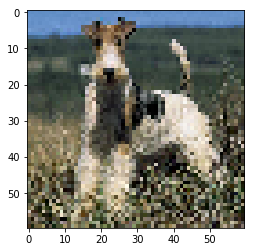

In [28]:
lum_img = train[1608,:,:,:]
plt.imshow(lum_img)
plt.show()
# train데이터가 잘 되었는지 확인해본다

In [30]:
labels_raw = pd.read_csv("labels.csv.zip", compression='zip', header=0, sep=',', quotechar='"')
# labels 압축파일을 가지고 온다

#랜덤하게 5개를 뽑아본다
labels_raw.sample(5)

,id,breed
751,12b72be0bcd7a96172fee4f7cd5b01fd,great_pyrenees
820,142ef9990b3db0d521f87f9133a6b84f,labrador_retriever
645,0fc12a365adfcbb603e298b10149632a,miniature_pinscher
8491,d530703b353991efcf62e7e10b8f7ee2,collie
7308,b72130fb5921d7a8711029fcd1f49e88,whippet


# 코드 만든 개발자의 조언
### We will reduce the data base so that we can reduce the complexity of our model. In addition, it will help for the calculation as there will be only N breeds to classify. We will be able to easily run the model in less than 10 minutes.

#### 프로젝트 설명을 보면 120종의 강아지가 있다고 되어있지만 코드를 짠 개발자는 복잡성도 줄이고 시간도 적게 들게 하기 위해 데이터베이스를 줄이려는 생각같다


In [31]:
Nber_of_breeds = 5
# 8개의 breed
# 아래 함수는 원래 breed는 120종이고 train,test 데이터도 120종의 강아지사진들이 들어있다 하지만 계산량과 시간을 고려해서
# 줄이는게 이 코드 개발자의 목적이였고 분별하려는 breeds수에 맞게 데이터들을 조정하는 함수 같다
# 나는 컴퓨터가 안좋기에 5개의 품종만 판별하기로 한다.

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])     
    #breeds마다 몇번 나왔는지 카운팅하는 함수, numpy array로 반환한다.
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> 내림차순 정렬
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 5 main breeds : (588,)
- The shape of train_filtered dataset is : (588, 60, 60, 3)


이렇게 해서 처음에 10222개의 120종 강아지 사진이 5개의 품종에 맞춰 다시 셋팅했더니 588개의 강아지 사진으로 줄어들었다.

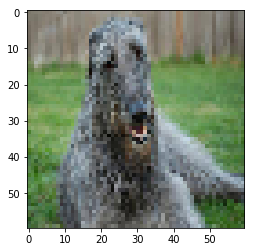

In [36]:
lum_img = train_filtered[216,:,:,:]
plt.imshow(lum_img)
plt.show()
# 우리가 다시 분류한 데이터에서 하나를 뽑아보자

### one_hot_encoding

In [38]:
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) 
labels.shape

(588, 1)

In [39]:
#본격적으로 one-hot-label하는 함수

def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [43]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:10]

Nber SubVariables 5
Shape : (588, 5)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

위의 값은 one-hot-encoding된 값을들 0~10까지 print한 값입니다

In [44]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))
#우리는 5개의 품종을 구별하기로 했는데 무엇인지 보기 위한 코드이다

Breed 0 : afghan_hound
Breed 1 : bernese_mountain_dog
Breed 2 : entlebucher
Breed 3 : maltese_dog
Breed 4 : scottish_deerhound


In [45]:
labels[0:10]

array([['scottish_deerhound'],
       ['maltese_dog'],
       ['scottish_deerhound'],
       ['entlebucher'],
       ['entlebucher'],
       ['maltese_dog'],
       ['bernese_mountain_dog'],
       ['entlebucher'],
       ['afghan_hound'],
       ['scottish_deerhound']], dtype=object)

In [47]:
labels_cls = np.argmax(labels_bin, axis=1)
labels_name[labels_cls[2]]
#labels의 3번째 one-hot-encoding값에 해당하는 품종이 무엇인지 본다, argmax를 사용할때 axis=1이면 행에서 가장 큰값, 0이면 해당 열에서 가장 큰 값을 가져온다

'scottish_deerhound'

scottish_deerhound


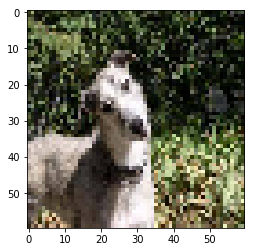

In [54]:
i=9
print(labels_name[labels_cls[i]])
lum_img = train_filtered[i,:,:,:]
plt.imshow(lum_img)
plt.show()
# 10번째 해당하는 값의 사진을 출력해본다

# 지금까지는 전처리하는 과정이고, 이제부터 CNN구조로 들어간다.


### train데이터를 나눌것이다. 보통 train,test데이터를 각각 다시 validation을 포함하도록 나눈다. 
### 여기선 30%비율로 나눌것이다

In [62]:
num_validation = 0.30
# 30% 비율
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)

print(X_train.shape)
print(X_validation.shape)
# X_train와 X_validation을 합하면 588이 나옵니다

(411, 60, 60, 3)
(177, 60, 60, 3)


In [64]:
df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]


array([1, 2, 3, 2, 3, 4, 3, 2, 0], dtype=int64)

maltese_dog
3


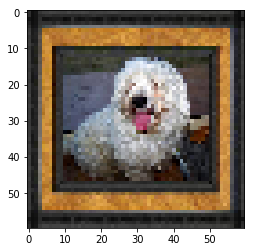

In [65]:
i=2
print(labels_name[df_validation_toPred_cls[i]])
print(df_validation_toPred_cls[i])
lum_img = X_validation[i,:,:,:]
plt.imshow(lum_img)
plt.show()

In [66]:
img_size = image_resize


num_channels = 3

#affine구조를 만들기위해 size*size를 해서 1차원 배열을 만들것이다
img_size_flat = img_size * img_size


img_shape = (img_size, img_size, num_channels)

# 5 breeds
num_classes = Nber_of_breeds

In [67]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
# tf.truncated_normal()는 평균에서 표준편차 이상의 값은 생성하지 않는다

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
# tf.constant(value, dtype=None, shape=None, name='Const') 

In [68]:
def new_conv_layer(input,              # input으로 전 layer를 받는다
                   num_input_channels, # 전 layer의 channel수를 받는다
                   filter_size,        # 필터 size
                   num_filters,        # 필터 갯수
                   use_pooling=True,   # pooling 사용여부, 2x2 max pooling사용
                   use_dropout=True):  # dropout 사용여부

    shape = [filter_size, filter_size, num_input_channels, num_filters]


    weights = new_weights(shape=shape)      # 초기 가중치를 설정(좋은 학습을 위해서)
    biases = new_biases(length=num_filters) # 초기 bias를 설정 (좋은 학습을 위해서)


    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    
    layer += biases

    
    if use_pooling:
        # 만약 pooling을 사용한다면 : 2x2 max_pooling을 사용 1,2,2,1 중 가운데 2,2가 2x2에 해당
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)  # 활성함수로 LeRU를 사용한다
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)
        
    return layer, weights

In [69]:
# 다음은 맨 마지막에 softmax를 쓰기 위해서는 평평하게 만드는, 즉, 데이터를 1차원으로 쭉 나열하는 과정이 필요하다

def flatten_layer(layer):
    # 매개변수로 전달받은  layer의 shape를 알아본다
    layer_shape = layer.get_shape()
    
    # layer_shape == [num_images, img_height, img_width, num_channels]
    # The number of features = img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    # layer_shape[1]은 height, [2]은 width, [3]은 channels이다 
    num_features = layer_shape[1:4].num_elements()
    
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    # 이렇게 해서 현재 feature의 shape은 아래의 형태이다
    # [num_images, img_height * img_width * num_channels]

    # layer_flat와 이미지갯수를 return한다
    return layer_flat, num_features

In [70]:
#softmax를 쓰기위한 fully_connected_layer이다.

def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True,
                 use_dropout=True): 

    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # 벡터내적곱의 연산과 bias를 더해준다. 
    layer = tf.matmul(input, weights) + biases

    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

# 이제 CNN을 돌리기 위해 placeholder를 선언해 준다.(텐서플로우의 방식)

In [71]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) #-1 put everything as 1 array
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

# 필터 사이즈, 갯수, FC_layer의 node수 등 설정

In [77]:
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 64         

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 128        


# Fully-connected layer.
fc_size = 100

In [78]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=True)


In [79]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [80]:
#Train

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc1

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)

layer_fc2

<tf.Tensor 'add_6:0' shape=(?, 5) dtype=float32>

In [81]:
#Prediction :
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

# CNN의 cost function = loss를 정의한다 ( cross_entropy)

In [83]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 지금까지는 코드를 정의한것이고 이제 Session을 활성시켜 코드를 돌려볼 차례이다

In [84]:
session = tf.Session()

def init_variables():
    session.run(tf.global_variables_initializer())

In [85]:
batch_size = 50
#batch_size는 한번에 몇개씩 학습할 것인가를 말한다 50개씩 가져온다.
#next_batch는 다음 batch를 가져오는 함수이다. 랜덤하게 가져온다.
def next_batch(num, data, labels):
    
    
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [89]:
# 최적화 함수이다

def optimize(epoch, X):
    global t_epoch
    
    start_time = time.time()
    
    #array to plot
    losses = {'train':[], 'validation':[]}
    
    #epoch은 쉽게 설명하면 100문제의 모의고사1회가 있는데 batch_size=10으로 하면 한번 문제를 풀때 10문제씩 푼다는 소리이고
    #10문제씩 10번이면 100문제로 모의고사1회가 끝난다, batch_size =10을 10번 반복하면 한 사이클이 끝나는데 이것을 epoch이 1이다라고 한다.
    #epoch을 설정해서 이 작업을 계속 반복시킨다.
    for i in range(epoch):
            t_epoch += 1
            
            
            x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

        
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch,
                               keep_prob_conv : 0.7,
                               keep_prob_fc : 0.7}
            # keep_prob_conv : 0.7이란 소리는 conv_layer에서 70%의 노드를 활성화 한다는 것이다, overfitting을 막기 위해 사용한다.
            # Keep_prob_fc는 fully_connected_layer에서 사용하는 drop_out비율이다.
            
            feed_dict_validation = {x: X_validation,
                               y_true: y_validation,
                               keep_prob_conv : 1,
                               keep_prob_fc : 1}
            
            # session을 run하고 실행한다
            session.run(optimizer, feed_dict=feed_dict_train)
            
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
            losses['train'].append(acc_train)
            losses['validation'].append(acc_validation)
            
            # t_epoch을 X로 나누었을 때 0이 될 때마다 정확도를 출력한다. 
            if (t_epoch % X == 0) or (i ==(epoch -1)):
            
                                
                msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
                print(msg.format(t_epoch, acc_train, acc_validation))
                
                
    end_time = time.time()

    
    time_dif = end_time - start_time

    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [90]:
init_variables()
t_epoch = 0

Iteration:    250, Training Accuracy:  60.0%, Validation Accuracy:  51.4%
Iteration:    500, Training Accuracy:  88.0%, Validation Accuracy:  61.0%
Iteration:    750, Training Accuracy:  94.0%, Validation Accuracy:  57.6%
Iteration:   1000, Training Accuracy: 100.0%, Validation Accuracy:  59.9%
Iteration:   1250, Training Accuracy:  94.0%, Validation Accuracy:  58.2%
Iteration:   1500, Training Accuracy: 100.0%, Validation Accuracy:  58.8%
Time usage: 0:42:26


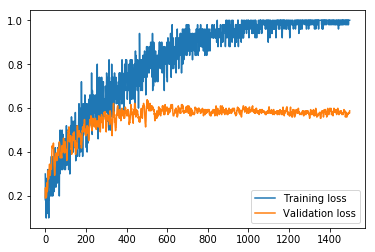

In [91]:
optimize(epoch=1500, X=250)

# 결과
### 캐글에 공개된 코드는 epoch: 3000, breeds =8, 이미지 대략900개를 사용했고
### training accuracy: 88% , validation accuracy : 40%가 나왔다

### 나는 컴퓨터가 안좋기 때문에 epoch : 1500, breeds =5 , 이미지 588개를 사용했다
### 그리고 conv층도 2개로 아주 간단하게 사용하였다. 
### 결과는 training Acc : 100%(오버피팅), validation Acc : 58.8%가 나왔다
### training은 오버피팅이 되어 버렸지만, validation은 40보다 18.8% 높게 나왔다.
### 오버피팅도 막고 정확도를 높일 수 있는 방법을 생각해보면
#### 1. 더 많은 데이터셋을 사용한다.
#### 2. 적당한 learning rate를 찾고, dropout비율도 찾는다.
#### 3. 전처리를 더 잘한다.
#### 4. 시작하기전 Weight, Bias를 적절하게 설정한다.
#### 5. 정규화를 잘한다
#### 6. 중복되는 데이터를 지운다
#### 등등 아주 많은 방법이 있다 (노가다를 해야한다)
